In [1]:
import os
import seaborn as sns

from matplotlib import pyplot as plt
from data_cleaning.processing_utils import (
    get_percentage_missing,
    get_entries_with_missing_values,
    plot_missing
)

In [2]:
import pandas as pd

file_path = '../data/prepared.parquet'
output_file_path = '../data/fix_noise.parquet'

if not os.path.exists(file_path):
    print(f"File not found: {file_path}")

df = pd.read_parquet(file_path)
# df.dtypes

In [3]:
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")
df.drop(columns=['AisSourcen'], inplace=True) #NOTE can be changed

df = df.drop_duplicates()
df = df.reset_index(drop=True)
len(df)

Number of duplicate rows: 0


913599

**1. Converting impossible values to NaN:**

- TH: should only have values 0-360, but has 500
**Heading (degrees) of the vessel's hull. A value of 511 indicates there is no heading data.**
[link](https://api.vtexplorer.com/docs/response-ais.html#:~:text=Heading%20(degrees)%20of%20the%20vessel's,there%20is%20no%20heading%20data.&text=Dimension%20(meters)%20from%20AIS%20GPS%20antenna%20to%20the%20Stern%20of,Vessel%20Length%20=%20A%20+%20B)
- COG: should only have values 0-360
--------------------------------
- Latitude one really low value
- SOG: 3 examples with superspeed ships
-------STATIC---------
- Length and Breadth should be positive
- Draught 0 and really high values


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

 Yes, a draft of 0.1 is certainly possible. The term "draft" refers to the vertical distance between the waterline and the lowest part of a ship's hull. This means that even a very small draft of 0.1 is possible, as it simply means the ship is sitting low in the water, possibly due to being lightly loaded or having a design that allows for minimal depth.



In [4]:
import numpy as np

df['Length'] = df['Length'].apply(lambda x: x if x > 0 else  np.nan)
df['Breadth'] = df['Breadth'].apply(lambda x: x if x > 0 else  np.nan)
df['Draught'] = df['Draught'].apply(lambda x: x if 0 < x else  np.nan)
df['shiptype'] = df['shiptype'].apply(lambda x: x if 0 < x else  np.nan)
df['Destination'] = df['Destination'].fillna(pd.NA)

df['TH'] = df['TH'].apply(lambda x: x if 0 <= x <= 360 or x == 511 else None)
df['COG'] = df['COG'].apply(lambda x: x if 0 <= x <= 360 else None)

# df['SOG'] = df['SOG'].apply(lambda x: x if x <= 60 else None)    #NOTE CAN BE CHANGED
# df.loc[df['SOG'] >= 60]

<Axes: >

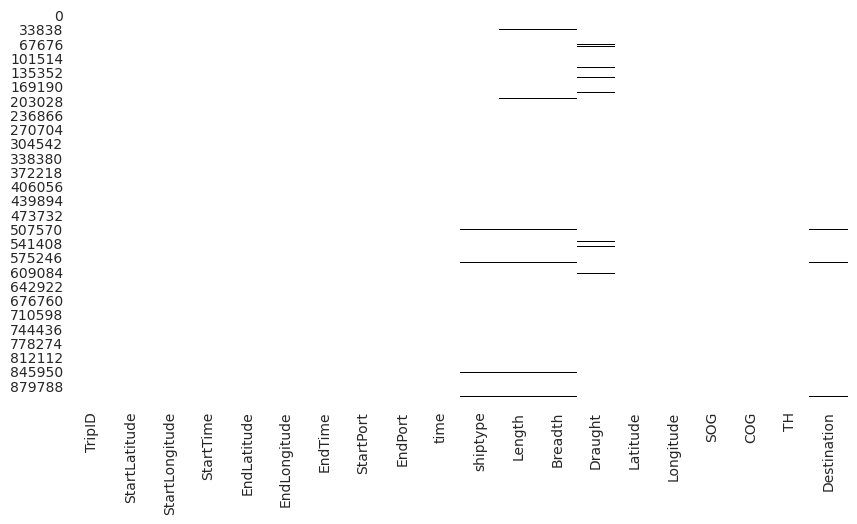

In [5]:
plot_missing(df)

In [6]:
get_percentage_missing(df)

TripID            0.000000
StartLatitude     0.000000
StartLongitude    0.000000
StartTime         0.000000
EndLatitude       0.000000
EndLongitude      0.000000
EndTime           0.000000
StartPort         0.000000
EndPort           0.000000
time              0.000000
shiptype          0.717820
Length            1.122593
Breadth           1.122593
Draught           1.784481
Latitude          0.000000
Longitude         0.000000
SOG               0.000000
COG               0.000109
TH                0.000000
Destination       0.575745
dtype: float64

| Parameter     | Missing % |
|---------------|-----------|
| Length        | 1.122565  |
| Breadth       | 1.122565  |
| Draught       | 1.784436  |
| COG           | 0.000109  |
| Destination   | 0.575840  |
| COG           | 0.000109  |
| shiptype      | 0.717820  |


After

| Parameter     | Missing % |
|---------------|-----------|
| Length        | 1.102234  |
| Breadth       | 1.108473  |
| Draught       | 1.779008  |
| COG           | 0.000109  |
| Destination   | 0.007443  |
| shiptype      | 0.704904  |

## 2. Destination

See if we can just fill in missing values with the nearest value within the same TripID

In [7]:
get_entries_with_missing_values(df, 'Destination')

TripID
5944       [PL.GDY, <NA>]
19002              [<NA>]
19585      [PL.GDY, <NA>]
23834      [PL.GDN, <NA>]
28257      [PL.GDN, <NA>]
                ...      
2183505    [PL.GDN, <NA>]
2200956            [<NA>]
2258835    [PL.GDY, <NA>]
2263639    [PL.GDN, <NA>]
2271342    [PL.GDN, <NA>]
Name: Destination, Length: 248, dtype: object

df.loc[df['TripID'] == 355595]  # Check the first trip with missing Destination
Not really but we can fill missing values with the nearest value within the same TripID and more matching coordinates.
Find the first nan value above and below it will fill it with the nearest value within the same TripID and more matching coordinates.

In [8]:
from data_cleaning.processing_utils import fill_missing_destinations_by_proximity

df_dest = fill_missing_destinations_by_proximity(df)
print(get_percentage_missing(df_dest, 'Destination'))

0.0074430904587242325


**No Destination at All**

In [9]:
get_entries_with_missing_values(df_dest, 'Destination')

TripID
19002      [<NA>]
2200956    [<NA>]
Name: Destination, dtype: object

### Functions

In [10]:
def get_inconsistent_trip_ids(df, column):
      return (
            df.groupby("TripID")[column]
            .apply(lambda x: x.dropna().nunique() > 1)
            .loc[lambda x: x]
            .index
        )


def make_inconsistent_mode(dataf, column):
    inconsistent_trip_ids = get_inconsistent_trip_ids(dataf, column)

    for trip_id in inconsistent_trip_ids:
        trip_mask = dataf["TripID"] == trip_id
        mode_values = dataf.loc[trip_mask, column].mode(dropna=True)

        if not mode_values.empty:
            # Replace ALL values (including nulls) with the first mode
            dataf.loc[trip_mask, column] = mode_values[0]

def all_fill_with_mode(dataf, column):
    print("-"* 40)
    print(" "*20,f"Before filling {column}")
    print(f"percentage of missing:" , get_percentage_missing(df_lbs, column))
    print("Inconsistent Trip IDs:\n", get_inconsistent_trip_ids(dataf, column))
    make_inconsistent_mode(dataf, column)
    print(" "*20, f"After filling {column}")
    print(f"percentage of missing:" , get_percentage_missing(dataf, column))
    print("Inconsistent Trip IDs:\n", get_inconsistent_trip_ids(dataf, column))
    print("-"* 40)




### 3 Length && Breadth && Shiptype

In [11]:
df_lbs = df_dest.copy()

In [12]:
all_fill_with_mode(df_lbs, 'Length')

----------------------------------------
                     Before filling Length
percentage of missing: 1.1225931727158194
Inconsistent Trip IDs:
 Index([ 365167,  393533,  393541,  424725,  448034,  647398,  647399,  688644,
        688665,  887590,  887598,  887609, 1130240, 1893675, 1929055, 2022611,
       2201111, 2263639],
      dtype='int64', name='TripID')
                     After filling Length
percentage of missing: 1.1022341311669561
Inconsistent Trip IDs:
 Index([], dtype='int64', name='TripID')
----------------------------------------


In [13]:
all_fill_with_mode(df_lbs, 'Breadth')

----------------------------------------
                     Before filling Breadth
percentage of missing: 1.1225931727158194
Inconsistent Trip IDs:
 Index([ 365167,  413659,  413667,  424725,  822859,  887590,  887598,  887609,
       1541749, 1542055, 1542074, 1633571, 2022611],
      dtype='int64', name='TripID')
                     After filling Breadth
percentage of missing: 1.108473192286769
Inconsistent Trip IDs:
 Index([], dtype='int64', name='TripID')
----------------------------------------


#### Shiptype

In [14]:
df_lbs['shiptype'] = df_lbs['shiptype'].apply(lambda x: x if 0 < x else None)

In [15]:
print(get_percentage_missing(df_lbs, 'shiptype'))

valid_trips = df_lbs.groupby('TripID')['shiptype'].transform(lambda x: x.notna().any())
# Forward-fill ONLY in trips that have at least one non-null shiptype
df_lbs['shiptype'] = (
    df_lbs.groupby('TripID')['shiptype']
    .ffill()
    .where(valid_trips)  # Keep filled values only in valid trips
    .combine_first(df_lbs['shiptype'])  # Restore original NaN where no fill occurred
)

print(get_percentage_missing(df_lbs, 'shiptype'))

0.7178204004163752
0.15291172604173167


In [16]:
get_entries_with_missing_values(df_lbs, 'shiptype')

TripID
19002      [nan]
1290901    [nan]
1866491    [nan]
1888742    [nan]
2200956    [nan]
Name: shiptype, dtype: object

<Axes: >

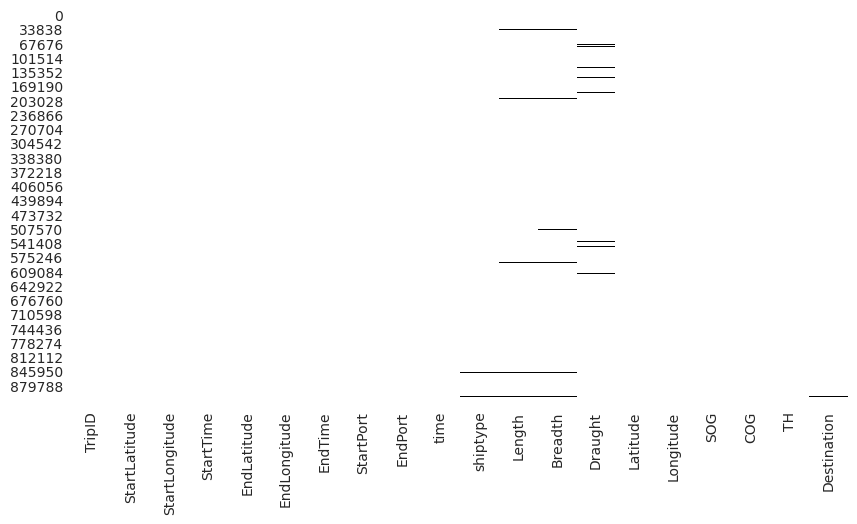

In [17]:
cols = df_lbs.columns
plt.figure(figsize = (10,5))
sns.heatmap(df_lbs[cols].isnull(), cmap=['white', 'black'], cbar=False)

As if see then ship type is missing together with Length and Breadth.
The mean doesn't make sense here
Idk what to do with it, now

Clustering is an option but I will bother with it later

#### Draught

In [18]:
df_drght = df_lbs.copy()

#### Not all nulls

In [19]:
# has none but at least one proper
mixed_draught_trips = (
    df_drght.groupby("TripID")["Draught"]
    .apply(lambda x: x.notna().any() and x.isna().any())
    .loc[lambda x: x]  # Filter only True cases
    .index
    .tolist()
)
mixed_draught_trips
#After looking in the data for this we can use median of the trip to fill in the missing values or interpolate

[1993380, 2035831]

In [20]:
print(get_percentage_missing(df_drght, 'Draught'))

trip_medians = df_drght[df_drght["TripID"].isin(mixed_draught_trips)].groupby("TripID")["Draught"].median()

df_drght_cp = df_drght.copy()
for trip_id in mixed_draught_trips:
    mask = (df_drght_cp["TripID"] == trip_id) & (df_drght_cp["Draught"].isna())
    df_drght_cp.loc[mask, "Draught"] = trip_medians[trip_id]

# df['Draught'] = df.groupby('TripID')['Draught'].interpolate()
print(get_percentage_missing(df_drght_cp, 'Draught'))

1.7844809374791346
1.7790080768477199


#### All nulls

In [21]:
# No values at all

trips_with_no_draught = df_drght_cp.groupby('TripID')['Draught'].apply(
    lambda x: x.isna().all()
)
no_draught_trip_ids = trips_with_no_draught[trips_with_no_draught].index.tolist()
no_draught_trip_ids

[134726,
 199665,
 370742,
 370750,
 370761,
 370767,
 370773,
 370779,
 370785,
 370805,
 370816,
 370827,
 447271,
 646698,
 719608,
 719625,
 754511,
 754519,
 820282,
 827699,
 886651,
 1059962]

#### Cog

In [22]:
df_cog = df_drght_cp.copy()

In [23]:
# df_cog['COG'].isnull()
# df_cog.loc[df_cog['TripID'] == 1778056]
#The null is last entry id data series
df_cog['COG'] = df_cog['COG'].fillna(0)

## All nulls for time entry

Draught higly colerated to Length and Breadth, so we can use them to fill in the missing values

In [24]:
print(df_cog['Draught'].corr(df_cog['Length']))
print(df_cog['Draught'].corr(df_cog['Breadth']))
print(df_cog['Length'].corr(df_cog['Breadth']))

0.8651403249540918
0.8556906959170374
0.9397658967630387


Train a HistGradientBoostingRegressor model to predict missing Draught values based on Length and Breadth:

In [25]:
from sklearn.metrics import r2_score
from sklearn.ensemble import HistGradientBoostingRegressor

# Function to fill missing values safely
def fill_missing(df, target_col, feature_cols):
    df_copy = df.copy()  # Work on a copy to avoid modifying the original DataFrame
    known = df_copy.dropna(subset=[target_col])
    missing = df_copy[df[target_col].isna()]

    if len(missing) == 0:
        return df  # No missing values to fill

    X_train = known[feature_cols]
    y_train = known[target_col]
    X_test = missing[feature_cols]

    model = HistGradientBoostingRegressor()
    model.fit(X_train, y_train)
    df_copy.loc[df_copy[target_col].isna(), target_col] = model.predict(X_test)
    print("R2 score", r2_score(y_train, model.predict(X_train)))

    return df_copy

print("Missing Draught (%):", get_percentage_missing(df_cog, 'Draught'))
print("Missing Length (%):", get_percentage_missing(df_cog, 'Length'))
print("Missing Breadth (%):", get_percentage_missing(df_cog, 'Breadth'))


# Fill Draught first (using Length + Breadth)
df_cog = fill_missing(df_cog, 'Draught', ['Length', 'Breadth'])

# Fill Length first (using Breadth + Draught)
df_cog = fill_missing(df_cog, 'Length', ['Breadth', 'Draught'])

# Then fill Breadth (using Length + Draught)
df_cog = fill_missing(df_cog, 'Breadth', ['Length', 'Draught'])

# Verify no missing values remain
print("Missing Draught (%):", df_cog['Draught'].isnull().sum() / len(df_cog) * 100)
print("Missing Length (%):", df_cog['Length'].isnull().sum() / len(df_cog) * 100)
print("Missing Breadth (%):", df_cog['Breadth'].isnull().sum() / len(df_cog) * 100)

Missing Draught (%): 1.7790080768477199
Missing Length (%): 1.1022341311669561
Missing Breadth (%): 1.108473192286769
R2 score 0.9539057872916767
R2 score 0.9920879724911014
R2 score 0.9973969504672946
Missing Draught (%): 0.0
Missing Length (%): 0.0
Missing Breadth (%): 0.0


### Save

TripID            0.000000
StartLatitude     0.000000
StartLongitude    0.000000
StartTime         0.000000
EndLatitude       0.000000
EndLongitude      0.000000
EndTime           0.000000
StartPort         0.000000
EndPort           0.000000
time              0.000000
shiptype          0.152912
Length            0.000000
Breadth           0.000000
Draught           0.000000
Latitude          0.000000
Longitude         0.000000
SOG               0.000000
COG               0.000000
TH                0.000000
Destination       0.007443
dtype: float64


<Axes: >

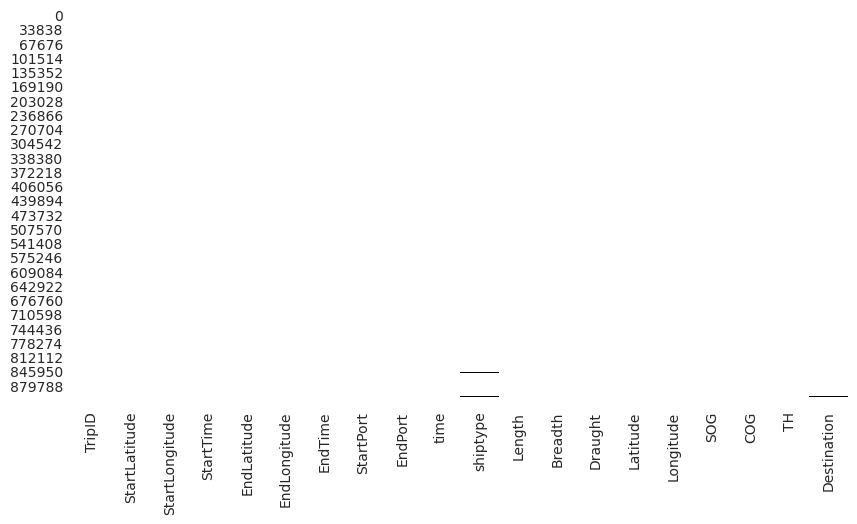

In [26]:
print(get_percentage_missing(df_cog))
plot_missing(df_cog)

In [29]:
df_final = df_cog.copy()

# Rename columns to match the desired format

In [38]:
column_mapping = {
    'TripID':           'trip_id',
    'StartLatitude':    'start_latitude',
    'StartLongitude':   'start_longitude',
    'StartTime':        'start_time',
    'EndLatitude':      'end_latitude',
    'EndLongitude':     'end_longitude',
    'EndTime':          'end_time',
    'StartPort':        'start_port',
    'EndPort':          'end_port',
    'time':             'time_stamp',
    'shiptype':         'ship_type',
    'Length':           'length',
    'Breadth':          'breadth',
    'Draught':          'draught',
    'Latitude':         'latitude',
    'Longitude':        'longitude',
    'SOG':              'speed_over_ground',
    'COG':              'course_over_ground',
    'TH':               'true_heading',
    'Destination':      'destination',
    'AisSourcen':       'ais_source'
}

# Apply renaming
df_final = df_final.rename(columns=column_mapping)

In [39]:
df_final.info


<bound method DataFrame.info of         trip_id  start_latitude  start_longitude                start_time  \
0         39131           53.57             8.53 2016-01-24 08:06:00+00:00   
1         39131           53.57             8.53 2016-01-24 08:06:00+00:00   
2         39131           53.57             8.53 2016-01-24 08:06:00+00:00   
3         39131           53.57             8.53 2016-01-24 08:06:00+00:00   
4         39131           53.57             8.53 2016-01-24 08:06:00+00:00   
...         ...             ...              ...                       ...   
913594  2204049           54.36            10.14 2017-04-03 07:54:00+00:00   
913595  2204049           54.36            10.14 2017-04-03 07:54:00+00:00   
913596  2204049           54.36            10.14 2017-04-03 07:54:00+00:00   
913597  2204049           54.36            10.14 2017-04-03 07:54:00+00:00   
913598  2204049           54.36            10.14 2017-04-03 07:54:00+00:00   

        end_latitude  end_longi

In [40]:
df_final.to_parquet(output_file_path)